In in this experiment, I selected images from 15% randomly selected videos and reserved as validation set. Which means: images in the training set come from different vidoes than images in validation set.

This is to test how well the model will generalize.

The result is not good. The prediction on validation set seems to be random.

This notebook is using (to my best knowledge) Transfer Learning :
- Download a well-known model, including its weights trained on ImageNet. I have tried VGG16, VGG19, ResNet, and DenseNet152.
- Kept all conv layers. Fix their paramters (not trainable).
- Flatten the last conv layer if needed.
- Connect 1 or 2 fully-connected layers at the top. This is the part that I'm the least confident about. Because the number of trainable parameters depends on it. I was told that I shouldn't have too many trainable parameters since my data set is not big. However, I tried one with 4000 trainable parameters, the training loss never went down.

The result: Overfitting

In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

img_width, img_height = 224,224
train_data_dir = "/data/generated/train-224"
validation_data_dir = "/data/generated/val-224"
batch_size = 16
epochs = 1000

# model = applications.densenet.DenseNet121(include_top=True, weights='imagenet', classes=1000)
model = applications.densenet.DenseNet121(include_top=True, weights='imagenet', input_shape = (img_width, img_height, 3), classes=1000)

model = applications.VGG19(include_top=False, weights='imagenet', input_shape = (img_width, img_height, 3))

for layer in model.layers:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 

model_final.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(lr=0.0002), metrics=["accuracy"])
#               optimizer='rmsprop',
#               metrics=['accuracy'])

model_final.summary()

/Users/kenneth/.pyenv/versions/3.6.1/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [2]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
vertical_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
shuffle=True,
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
batch_size = batch_size,
target_size = (img_height, img_width),
shuffle=True,
class_mode = "categorical")

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("all_videos.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


Found 229869 images belonging to 2 classes.
Found 9157 images belonging to 2 classes.


In [6]:
model_final.fit_generator(
    train_generator,
#     steps_per_epoch=nb_train_samples // batch_size,
    steps_per_epoch=200,
    epochs=epochs,
    validation_data=validation_generator,
#     validation_steps=nb_validation_samples // batch_size,
    validation_steps=50,
    callbacks = [checkpoint, early])

Epoch 1/50
 64/200 [========>.....................] - ETA: 34s - loss: 0.5008 - acc: 0.8682

KeyboardInterrupt: 

Performance test.

In [4]:
import keras
import os
import numpy as np
import pandas as pd
from PIL import Image
import glob
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import matplotlib.pyplot as plt

model_name = 'model.h5'

model = keras.models.load_model(model_name)
model.summary()

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="float32" )/255.0
    return data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

Here is how this classification model can be used to predict defect:
- Instead of relying the model's prediction whether or not an image is "bad", the output (softmax activation) of "bad" class is taken, and treated as the probability of this image is bad.
- Then we calcuate the rolling average of this probability to smooth out the noises
- When we detect a significant "jump" of the rolling average, we have a high confidence that a defect just happened.

In this case, the rolling average jumpped from a level well below 0.3 to well above 0.3, and hence we can confidently predict a defect.

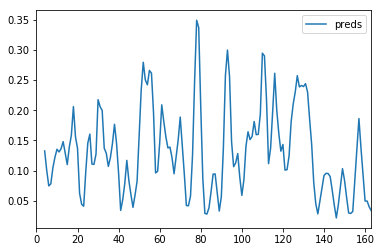

In [22]:
import matplotlib.image as mpimg
import glob

prefix = '527437885'
folder = 'val/best/'

plt.figure(figsize=(20,20))
columns = 16

jpgs = glob.glob(folder + prefix + '-*.jpg')
imgs = np.asarray(list(map(load_image, jpgs)))

preds = model.predict(imgs)
df = pd.DataFrame(dict(preds=preds[:,1]))
df = df.rolling(5, win_type='triang').mean()
df.plot()

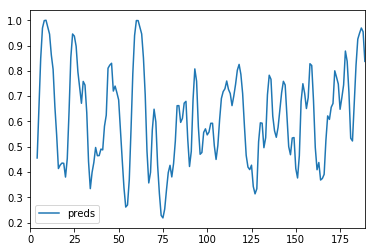

In [23]:
folder = 'val/worst/'
jpgs = glob.glob(folder + prefix + '-*.jpg')
imgs = np.asarray(list(map(load_image, jpgs)))

preds_bad = model.predict(imgs)
df = pd.DataFrame(dict(preds=preds_bad[:,1]))
df = df.rolling(5, win_type='triang').mean()
df.plot()